In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix, classification_report
import os
import cv2
from PIL import Image
from tqdm import tqdm
try:
    from model1 import AgeDetectionResNet, GradCAM, overlay_heatmap
except ImportError as e:
    print(f"ImportError: {e}")
    print("Ensure model.py is in the same directory and contains AgeDetectionResNet, GradCAM, overlay_heatmap")
    exit()

# Set random seed
torch.manual_seed(42)
np.random.seed(42)

# Verify working directory
print(f"Current working directory: {os.getcwd()}")

Current working directory: c:\Documents\New folder\ag2


In [2]:
# 1. Dataset Preparation
class UTKFaceDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images = []
        self.ages = []
        
        for filename in os.listdir(data_dir):
            if filename.endswith('.jpg'):
                try:
                    age = float(filename.split('_')[0])  # Numerical age
                    self.images.append(os.path.join(data_dir, filename))
                    self.ages.append(age)
                except:
                    print(f"Skipping invalid file: {filename}")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except:
            print(f"Error loading image: {img_path}")
            return None
        age = self.ages[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, torch.tensor(age, dtype=torch.float32)

In [3]:
# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:

# Load dataset'
data_dir = r"c:\Users\ponna\Downloads\drive-download-20250525T175035Z-1-001\part1\part1"
try:
    train_dataset = UTKFaceDataset(data_dir, transform=train_transform)
    val_dataset = UTKFaceDataset(data_dir, transform=val_transform)
except Exception as e:
    print(f"Error loading dataset: {e}")
    exit()


In [5]:

# Split into train/val (80-20)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [6]:
# Split into train/val (80-20)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [7]:
# Class names for binned ages
class_names = ['0-20', '21-40', '41-60', '61+']

In [8]:
# 2. Model Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AgeDetectionResNet().to(device)
criterion = nn.MSELoss()  # Regression loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:

# 4. Predict Ages for Three Images
model.load_state_dict(torch.load('weights/resnet18_age_regression.pth', map_location=device))
model.eval()
grad_cam = GradCAM(model, model.model.layer4[-1])


In [10]:

# Select three random images
image_files = [f for f in os.listdir(data_dir) if f.endswith('.jpg')]
if len(image_files) < 3:
    print(f"Error: Found only {len(image_files)} images in {data_dir}. Need at least 3.")
    exit()
np.random.seed(42)
selected_images = np.random.choice(image_files, 3, replace=False)


In [11]:
# Helper function to bin ages into classes
def bin_age(age):
    if age <= 20:
        return 0  # '0-20'
    elif age <= 40:
        return 1  # '21-40'
    elif age <= 60:
        return 2  # '41-60'
    else:
        return 3  # '61+'

# 3. Training Loop
num_epochs = 20
best_mae = float('inf')
os.makedirs('weights', exist_ok=True)
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, ages in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        if images is None:
            continue
        images, ages = images.to(device), ages.to(device)
        optimizer.zero_grad()
        outputs = model(images).squeeze()
        loss = criterion(outputs, ages)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}')
    
    # Validation
    model.eval()
    preds = []
    trues = []
    binned_preds = []
    binned_trues = []
    with torch.no_grad():
        for images, ages in val_loader:
            if images is None:
                continue
            images, ages = images.to(device), ages.to(device)
            outputs = model(images).squeeze()
            preds.extend(outputs.cpu().numpy())
            trues.extend(ages.cpu().numpy())
            # Bin ages for classification metrics
            binned_preds.extend([bin_age(p) for p in outputs.cpu().numpy()])
            binned_trues.extend([bin_age(t) for t in ages.cpu().numpy()])
    
    mae = mean_absolute_error(trues, preds)
    mse = mean_squared_error(trues, preds)
    accuracy = 100 * np.mean(np.array(binned_preds) == np.array(binned_trues))
    print(f'Validation MAE: {mae:.2f} years, MSE: {mse:.2f}, Binned Accuracy: {accuracy:.2f}%')
    
    # Save best model
    if mae < best_mae:
        best_mae = mae
        torch.save(model.state_dict(), 'weights/resnet18_age_regression.pth')

print(f'Best Validation MAE: {best_mae:.2f} years')
if best_mae > 5:
    print("Warning: MAE > 5 years. Consider more epochs or enhanced augmentation.")

Epoch 1/20:   0%|          | 0/242 [00:00<?, ?it/s]c:\Documents\New folder\ag2\.venv\Lib\site-packages\torch\nn\modules\module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Epoch 1/20: 100%|█████████▉| 241/242 [06:33<00:01,  1.85s/it]c:\Documents\New folder\ag2\.venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1/20: 100%|██████████| 242/242 [06:33<00:00,  1.63s/it]


Epoch 1, Loss: 201.7274
Validation MAE: 15.51 years, MSE: 393.76, Binned Accuracy: 45.15%


Epoch 2/20:   0%|          | 0/242 [00:00<?, ?it/s]c:\Documents\New folder\ag2\.venv\Lib\site-packages\torch\nn\modules\module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Epoch 2/20: 100%|█████████▉| 241/242 [07:20<00:01,  1.93s/it]c:\Documents\New folder\ag2\.venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 2/20: 100%|██████████| 242/242 [07:20<00:00,  1.82s/it]


Epoch 2, Loss: 171.4108
Validation MAE: 9.02 years, MSE: 157.06, Binned Accuracy: 65.01%


Epoch 3/20:   0%|          | 0/242 [00:00<?, ?it/s]c:\Documents\New folder\ag2\.venv\Lib\site-packages\torch\nn\modules\module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Epoch 3/20: 100%|█████████▉| 241/242 [07:18<00:01,  1.82s/it]c:\Documents\New folder\ag2\.venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 3/20: 100%|██████████| 242/242 [07:19<00:00,  1.81s/it]


Epoch 3, Loss: 157.3454
Validation MAE: 9.87 years, MSE: 179.05, Binned Accuracy: 63.82%


Epoch 4/20:   0%|          | 0/242 [00:00<?, ?it/s]c:\Documents\New folder\ag2\.venv\Lib\site-packages\torch\nn\modules\module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Epoch 4/20: 100%|█████████▉| 241/242 [09:07<00:02,  2.37s/it]c:\Documents\New folder\ag2\.venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 4/20: 100%|██████████| 242/242 [09:07<00:00,  2.26s/it]


Epoch 4, Loss: 142.2617
Validation MAE: 8.84 years, MSE: 151.06, Binned Accuracy: 69.00%


Epoch 5/20:   0%|          | 0/242 [00:00<?, ?it/s]c:\Documents\New folder\ag2\.venv\Lib\site-packages\torch\nn\modules\module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Epoch 5/20: 100%|█████████▉| 241/242 [09:33<00:02,  2.79s/it]c:\Documents\New folder\ag2\.venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 5/20: 100%|██████████| 242/242 [09:33<00:00,  2.37s/it]


Epoch 5, Loss: 128.1259
Validation MAE: 8.74 years, MSE: 158.72, Binned Accuracy: 68.95%


Epoch 6/20:   0%|          | 0/242 [00:00<?, ?it/s]c:\Documents\New folder\ag2\.venv\Lib\site-packages\torch\nn\modules\module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Epoch 6/20: 100%|█████████▉| 241/242 [03:43<00:00,  1.13it/s]c:\Documents\New folder\ag2\.venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 6/20: 100%|██████████| 242/242 [03:43<00:00,  1.08it/s]


Epoch 6, Loss: 126.2041
Validation MAE: 9.06 years, MSE: 170.54, Binned Accuracy: 68.38%


Epoch 7/20:   0%|          | 0/242 [00:00<?, ?it/s]c:\Documents\New folder\ag2\.venv\Lib\site-packages\torch\nn\modules\module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Epoch 7/20: 100%|█████████▉| 241/242 [03:46<00:00,  1.07it/s]c:\Documents\New folder\ag2\.venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 7/20: 100%|██████████| 242/242 [03:46<00:00,  1.07it/s]


Epoch 7, Loss: 115.0744
Validation MAE: 9.13 years, MSE: 152.53, Binned Accuracy: 65.89%


Epoch 8/20:   0%|          | 0/242 [00:00<?, ?it/s]c:\Documents\New folder\ag2\.venv\Lib\site-packages\torch\nn\modules\module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Epoch 8/20: 100%|█████████▉| 241/242 [03:45<00:00,  1.10it/s]c:\Documents\New folder\ag2\.venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 8/20: 100%|██████████| 242/242 [03:45<00:00,  1.07it/s]


Epoch 8, Loss: 110.8978
Validation MAE: 8.94 years, MSE: 179.19, Binned Accuracy: 69.21%


Epoch 9/20:   0%|          | 0/242 [00:00<?, ?it/s]c:\Documents\New folder\ag2\.venv\Lib\site-packages\torch\nn\modules\module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Epoch 9/20: 100%|█████████▉| 241/242 [03:50<00:01,  1.03s/it]c:\Documents\New folder\ag2\.venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 9/20: 100%|██████████| 242/242 [03:50<00:00,  1.05it/s]


Epoch 9, Loss: 97.9401
Validation MAE: 13.28 years, MSE: 338.09, Binned Accuracy: 57.02%


Epoch 10/20:   0%|          | 0/242 [00:00<?, ?it/s]c:\Documents\New folder\ag2\.venv\Lib\site-packages\torch\nn\modules\module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Epoch 10/20: 100%|█████████▉| 241/242 [05:18<00:01,  1.47s/it]c:\Documents\New folder\ag2\.venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 10/20: 100%|██████████| 242/242 [05:18<00:00,  1.32s/it]


Epoch 10, Loss: 96.3000
Validation MAE: 8.07 years, MSE: 126.82, Binned Accuracy: 70.24%


Epoch 11/20:   0%|          | 0/242 [00:00<?, ?it/s]c:\Documents\New folder\ag2\.venv\Lib\site-packages\torch\nn\modules\module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Epoch 11/20: 100%|█████████▉| 241/242 [05:35<00:01,  1.01s/it]c:\Documents\New folder\ag2\.venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 11/20: 100%|██████████| 242/242 [05:36<00:00,  1.39s/it]


Epoch 11, Loss: 90.5723
Validation MAE: 8.39 years, MSE: 141.92, Binned Accuracy: 70.97%


Epoch 12/20:   0%|          | 0/242 [00:00<?, ?it/s]c:\Documents\New folder\ag2\.venv\Lib\site-packages\torch\nn\modules\module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Epoch 12/20: 100%|█████████▉| 241/242 [05:43<00:01,  1.53s/it]c:\Documents\New folder\ag2\.venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 12/20: 100%|██████████| 242/242 [05:43<00:00,  1.42s/it]


Epoch 12, Loss: 83.3458
Validation MAE: 9.61 years, MSE: 173.51, Binned Accuracy: 65.58%


Epoch 13/20:   0%|          | 0/242 [00:00<?, ?it/s]c:\Documents\New folder\ag2\.venv\Lib\site-packages\torch\nn\modules\module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Epoch 13/20: 100%|█████████▉| 241/242 [04:22<00:01,  1.03s/it]c:\Documents\New folder\ag2\.venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 13/20: 100%|██████████| 242/242 [04:22<00:00,  1.09s/it]


Epoch 13, Loss: 81.2625
Validation MAE: 8.17 years, MSE: 131.28, Binned Accuracy: 70.30%


Epoch 14/20:   0%|          | 0/242 [00:00<?, ?it/s]c:\Documents\New folder\ag2\.venv\Lib\site-packages\torch\nn\modules\module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Epoch 14/20: 100%|█████████▉| 241/242 [05:29<00:01,  1.35s/it]c:\Documents\New folder\ag2\.venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 14/20: 100%|██████████| 242/242 [05:29<00:00,  1.36s/it]


Epoch 14, Loss: 71.0664
Validation MAE: 8.39 years, MSE: 142.66, Binned Accuracy: 70.87%


Epoch 15/20:   0%|          | 0/242 [00:00<?, ?it/s]c:\Documents\New folder\ag2\.venv\Lib\site-packages\torch\nn\modules\module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Epoch 15/20: 100%|█████████▉| 241/242 [04:58<00:01,  1.47s/it]c:\Documents\New folder\ag2\.venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 15/20: 100%|██████████| 242/242 [04:59<00:00,  1.24s/it]


Epoch 15, Loss: 69.8646
Validation MAE: 7.94 years, MSE: 131.29, Binned Accuracy: 69.78%


Epoch 16/20:   0%|          | 0/242 [00:00<?, ?it/s]c:\Documents\New folder\ag2\.venv\Lib\site-packages\torch\nn\modules\module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Epoch 16/20: 100%|█████████▉| 241/242 [04:59<00:01,  1.12s/it]c:\Documents\New folder\ag2\.venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 16/20: 100%|██████████| 242/242 [05:00<00:00,  1.24s/it]


Epoch 16, Loss: 71.2830
Validation MAE: 7.78 years, MSE: 122.39, Binned Accuracy: 72.06%


Epoch 17/20:   0%|          | 0/242 [00:00<?, ?it/s]c:\Documents\New folder\ag2\.venv\Lib\site-packages\torch\nn\modules\module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Epoch 17/20: 100%|█████████▉| 241/242 [05:21<00:01,  1.34s/it]c:\Documents\New folder\ag2\.venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 17/20: 100%|██████████| 242/242 [05:21<00:00,  1.33s/it]


Epoch 17, Loss: 58.1422
Validation MAE: 8.52 years, MSE: 145.87, Binned Accuracy: 67.60%


Epoch 18/20:   0%|          | 0/242 [00:00<?, ?it/s]c:\Documents\New folder\ag2\.venv\Lib\site-packages\torch\nn\modules\module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Epoch 18/20: 100%|█████████▉| 241/242 [05:37<00:01,  1.36s/it]c:\Documents\New folder\ag2\.venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 18/20: 100%|██████████| 242/242 [05:38<00:00,  1.40s/it]


Epoch 18, Loss: 72.5706
Validation MAE: 8.66 years, MSE: 146.29, Binned Accuracy: 67.96%


Epoch 19/20:   0%|          | 0/242 [00:00<?, ?it/s]c:\Documents\New folder\ag2\.venv\Lib\site-packages\torch\nn\modules\module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Epoch 19/20: 100%|█████████▉| 241/242 [05:41<00:01,  1.37s/it]c:\Documents\New folder\ag2\.venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 19/20: 100%|██████████| 242/242 [05:41<00:00,  1.41s/it]


Epoch 19, Loss: 70.6885
Validation MAE: 7.94 years, MSE: 129.43, Binned Accuracy: 69.31%


Epoch 20/20:   0%|          | 0/242 [00:00<?, ?it/s]c:\Documents\New folder\ag2\.venv\Lib\site-packages\torch\nn\modules\module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Epoch 20/20: 100%|█████████▉| 241/242 [05:33<00:01,  1.32s/it]c:\Documents\New folder\ag2\.venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 20/20: 100%|██████████| 242/242 [05:33<00:00,  1.38s/it]


Epoch 20, Loss: 53.4758
Validation MAE: 7.88 years, MSE: 132.35, Binned Accuracy: 71.38%
Best Validation MAE: 7.78 years


In [12]:
# 4. Classification Metrics
conf_matrix = confusion_matrix(binned_trues, binned_preds)
print("\nClassification Report:")
print(classification_report(binned_trues, binned_preds, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

        0-20       0.84      0.71      0.77       417
       21-40       0.79      0.79      0.79       995
       41-60       0.45      0.47      0.46       331
         61+       0.61      0.77      0.68       186

    accuracy                           0.71      1929
   macro avg       0.67      0.68      0.67      1929
weighted avg       0.72      0.71      0.72      1929



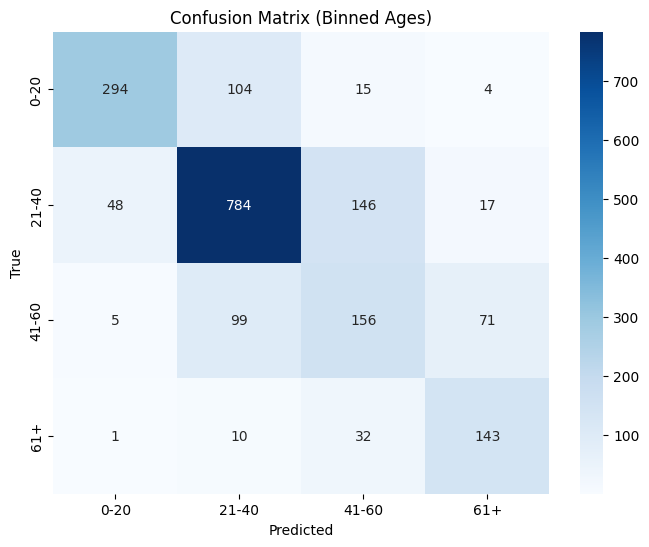

In [13]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Binned Ages)')
plt.show()


In [14]:
# 5. Predict Ages for Three Images
model.load_state_dict(torch.load('weights/resnet18_age_regression.pth', map_location=device))
model.eval()
grad_cam = GradCAM(model, model.model.layer4[-1])

In [15]:
# Select three random images
image_files = [f for f in os.listdir(data_dir) if f.endswith('.jpg')]
if len(image_files) < 3:
    print(f"Error: Found only {len(image_files)} images in {data_dir}. Need at least 3.")
    exit()
np.random.seed(42)
selected_images = np.random.choice(image_files, 3, replace=False)

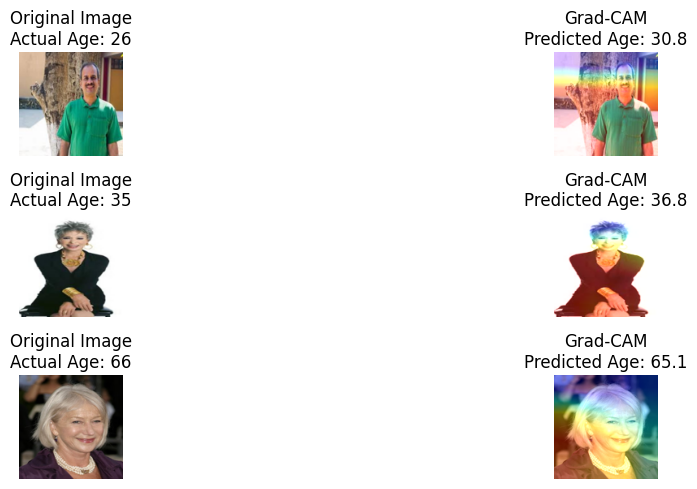

In [17]:
# Select three random images
image_files = [f for f in os.listdir(data_dir) if f.endswith('.jpg')]
if len(image_files) < 3:
    print(f"Error: Found only {len(image_files)} images in {data_dir}. Need at least 3.")
    exit()
np.random.seed(42)
selected_images = np.random.choice(image_files, 3, replace=False)

# Process each image
plt.figure(figsize=(15, 5))
for i, img_file in enumerate(selected_images):
    img_path = os.path.join(data_dir, img_file)
    
    # Extract actual age
    try:
        actual_age = float(img_file.split('_')[0])
    except:
        print(f"Error: Invalid filename format for {img_file}. Skipping.")
        continue
    
    # Load and preprocess image
    image = Image.open(img_path).convert('RGB')
    image_tensor = val_transform(image).unsqueeze(0).to(device)
    image_np = np.array(image.resize((128, 128)))
    
    # Predict age
    with torch.no_grad():
        pred_age = model(image_tensor).squeeze().item()
    
    # Generate Grad-CAM heatmap
    heatmap = grad_cam.generate(image_tensor, target=torch.tensor([[1.0]], device=device))
    superimposed_img = overlay_heatmap(heatmap, image_np)
    
    # Plot
    plt.subplot(3, 2, 2*i+1)
    plt.imshow(image_np)
    plt.title(f'Original Image\nActual Age: {actual_age:.0f}')
    plt.axis('off')
    
    plt.subplot(3, 2, 2*i+2)
    plt.imshow(superimposed_img)
    plt.title(f'Grad-CAM\nPredicted Age: {pred_age:.1f}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [18]:

# Print prediction summary
print("\nPrediction Summary:")
for img_file in selected_images:
    try:
        actual_age = float(img_file.split('_')[0])
    except:
        print(f"Error: Invalid filename format for {img_file}. Skipping.")
        continue
    image = Image.open(os.path.join(data_dir, img_file)).convert('RGB')
    image_tensor = val_transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        pred_age = model(image_tensor).squeeze().item()
    print(f"Image: {img_file}, Actual Age: {actual_age:.0f}, Predicted Age: {pred_age:.1f}")


Prediction Summary:
Image: 26_0_3_20170119181351882.jpg, Actual Age: 26, Predicted Age: 30.8
Image: 35_1_0_20170117192840324.jpg, Actual Age: 35, Predicted Age: 36.8
Image: 66_1_0_20170110132123247.jpg, Actual Age: 66, Predicted Age: 65.1
